### **RNN Architecture**

A recurrent neural network (RNN) is a class of artificial neural networks for which we have some kind of internal state (memory) and it can be used to process variable length sequence of inputs. This makes them applicable to tasks such as speech recognition and text generation.

**Types of RNN**

We have 4 different types of RNN:


1.   Vector to Sequence
2.   Sequence to Vector
3.   Sequence to Vector to Sequence
4.   Sequence to Sequence

For this project we are using the fourth type Sequence to Sequence.
In this network, as we start feeding input to the network it starts generating outputs. Text suggestion applications are an example of RNN architecture.


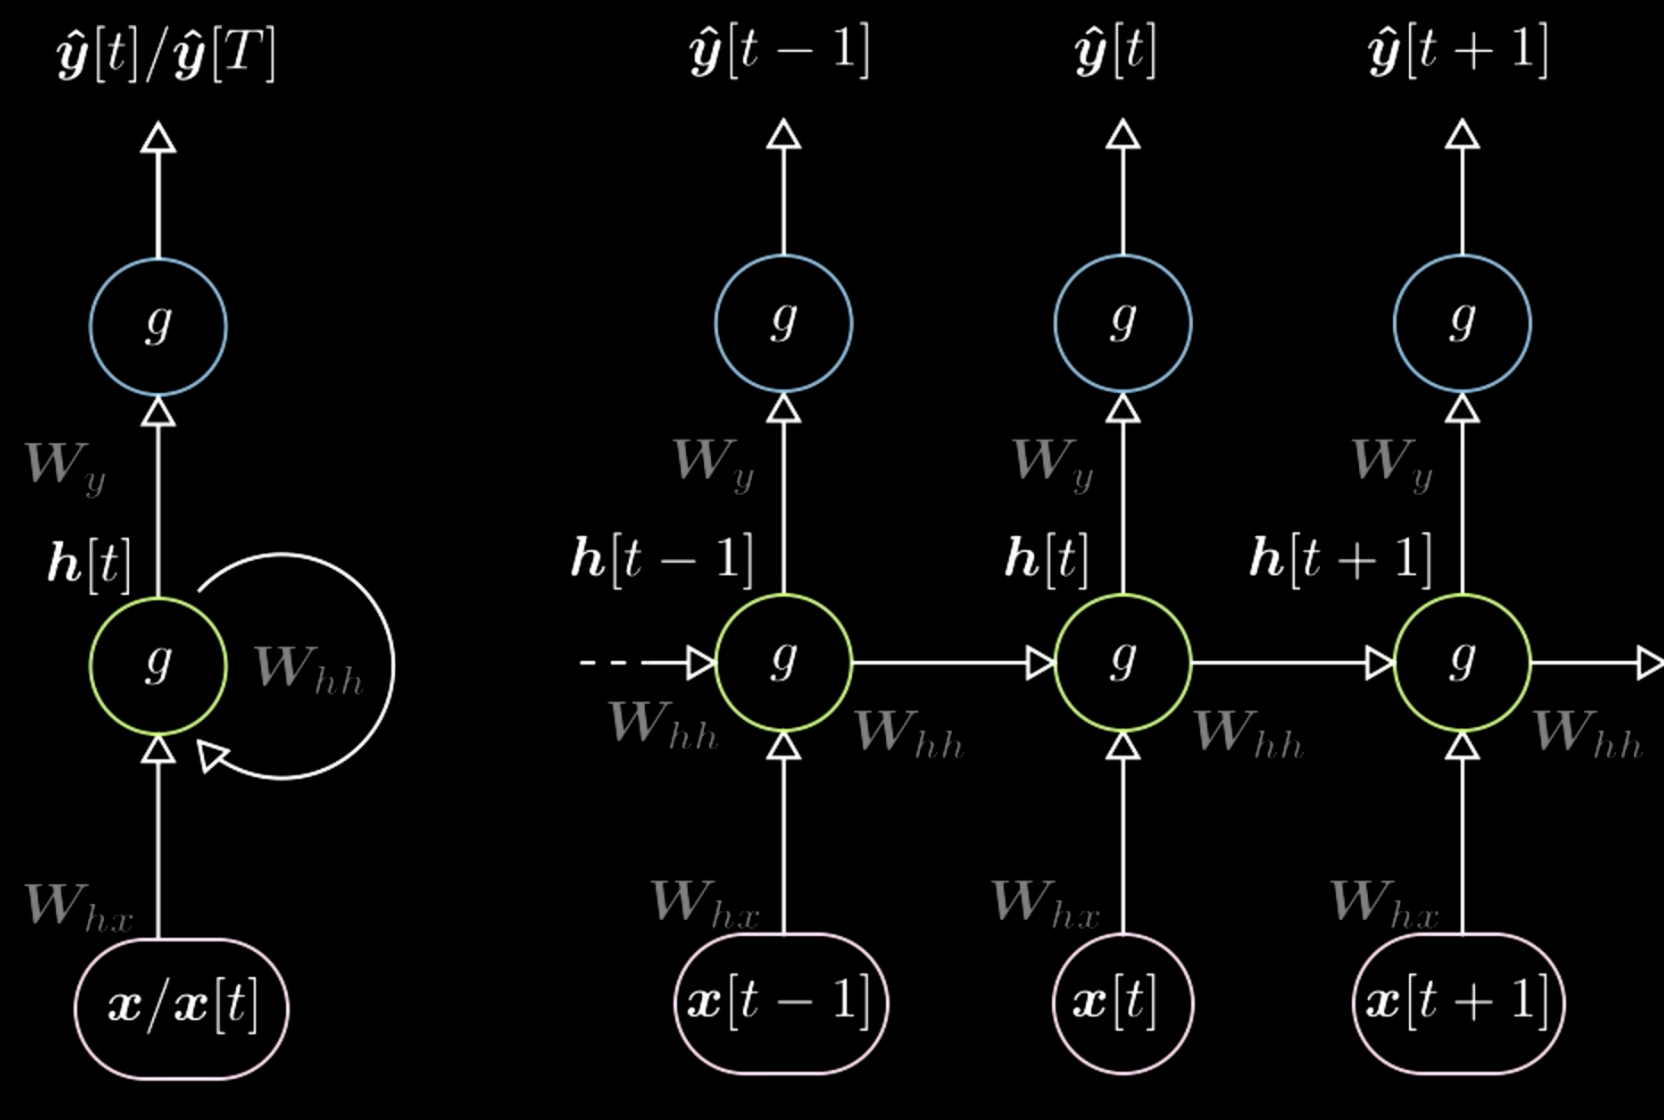






## **Markov Chains**

Markov chains, are probablistic systems that jump from one "state" (a situation or set of values) to another.

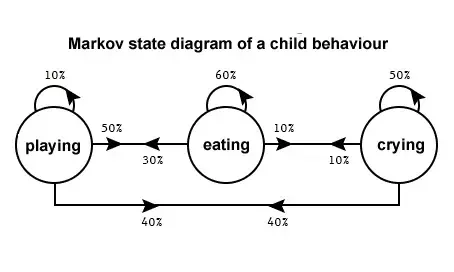

For example, with 3 states only, we have 8 possible transitions, because a state can transit back to itself.
We can create a transition matrix. In this matrix every state is included once as a row and once as a column and each cell in the matrix shows the probability of transitioning from its row state to its column state. 

$(P_t)_i,_j = \mathbb{P}(X_{t+1} = j \mid X_t = i)$

So each row of transition matrix is a probability vector and the sum of its entries is 1.

## **Bleu Score**

The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.

A perfect match is a score of 1.0, and a perfect mismatch is a score of 0.0. A value of 0 means that the generated text has no overlap with the reference text (low quality) while a value of 1 means there is perfect overlap with the corpus (high quality). BLEU scores correlate well with human judgment of text generation quality. 

The BLEU score was proposed by Kishore Papineni, et al. in their 2002 paper “BLEU: a Method for Automatic Evaluation of Machine Translation“.

The Bleu score works by counting the number of matching n-grams in the generation outputs to n-grams in the corpus. The comparison is not made based on order of words.

$$
 \text{BLEU} = \underbrace{\vphantom{\prod_i^4}\min\Big(1,
       \exp\big(1-\frac{\text{reference-length}}
    {\text{output-length}}\big)\Big)}_{\text{brevity penalty}}
 \underbrace{\Big(\prod_{i=1}^{4}
    precision_i\Big)^{1/4}}_{\text{n-gram overlap}}
$$
And\
$$ precision_i =  \frac{\sum_{\text{snt}\in\text{Cand-Corpus}}\sum_{i\in\text{snt}}\min(m^i_{cand}, m^i_{ref})}{w_t^i = \sum_{\text{snt'}\in\text{Cand-Corpus}}\sum_{i' \in \text{snt'}}m^{i'}_{cand}}
$$

Where\
$\bullet m^i_{cand}$ is the count of i-gram in candidate matching the reference text\

$\bullet m^i_{ref}$ is the count of i-gram in the reference text\

$\bullet w^i_{t}$ is the total number of i-grams in candidate text\

The formula has two parts: the brevity penalty and the n-gram overlap.



*   **Brevity Penalty**\
The brevity penalty check for the generated outputs that are too short compared to our reference text. It compensates for the fact that the BLEU score has no recall term.
*   **N-Gram Overlap**\
The n-gram overlap checks how many unigrams or i-grams (for i=1,...,4) match their associated n-gram in the reference text. We can think of this term as a precision metric. To avoid overcounting, the n-gram counts are clipped to the maximal n-gram count occurring in the reference $(m^n_{ref})$



## **Validation**

For Validating the generated results, we took 2 approaches:


1.   Comparing the length distribution of generated results with refrence inputs
2.   Calculating Bleu Score



# Dataset

The dataset in this project comes from two open source projects: amPEPpy and AMPlify. 

In [ ]:
!pip install biopython
!wget https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/AMP_20190407.fa
!wget https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/non_AMP_20190413.fa
!wget https://raw.githubusercontent.com/tlawrence3/amPEPpy/master/training_data/M_model_train_AMP_sequence.numbered.fasta
!wget https://raw.githubusercontent.com/tlawrence3/amPEPpy/master/training_data/M_model_train_nonAMP_sequence.numbered.fasta

     |████████████████████████████████| 2.3MB 5.6MB/s 
--2021-05-01 07:30:28--  https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/AMP_20190407.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166037 (162K) [text/plain]
Saving to: ‘AMP_20190407.fa’

AMP_20190407.fa     100%[===================>] 162.15K  --.-KB/s    in 0.03s   

2021-05-01 07:30:29 (5.76 MB/s) - ‘AMP_20190407.fa’ saved [166037/166037]

--2021-05-01 07:30:29--  https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/non_AMP_20190413.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, aw

In [ ]:
from Bio import SeqIO
import matplotlib.pyplot as plt

In [ ]:
def fasta_to_str_set(name):
  return {str(rec.seq) for rec in SeqIO.parse(name, 'fasta')}

In [ ]:
positive_examples = fasta_to_str_set('AMP_20190407.fa').union(fasta_to_str_set('M_model_train_AMP_sequence.numbered.fasta'))
negative_examples = fasta_to_str_set('non_AMP_20190413.fa').union(fasta_to_str_set('M_model_train_nonAMP_sequence.numbered.fasta'))

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math
import h5py
import torch
import torch.nn as nn
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader

# BeLU Score

In [ ]:
def n_gram_generator(sent_arr,n= 2,n_gram= False):
    length = len(sent_arr)

    word_list = []
    for i in range(length+1):
        if i < n:
            continue
        s_list = sent_arr[i-n:i]
        word_list.append(s_list)
        if n_gram:
            word_list = list(set(word_list))
    return word_list

def bleu_score(original,machine_translated):
    '''
    Bleu score function given a orginal and a machine translated sentences
    '''
    mt_length = len(machine_translated)
    o_length = len(original)

    # Brevity Penalty 
    if mt_length>o_length:
        BP=1
    else:
        penality=1-(mt_length/o_length)
        BP=np.exp(penality)

    # Clipped precision
    clipped_precision_score = []
    for i in range(1, 5):
        original_n_gram = Counter(n_gram_generator(original,i))
        machine_n_gram = Counter(n_gram_generator(machine_translated,i))

        c = sum(machine_n_gram.values())
        for j in machine_n_gram:
            if j in original_n_gram:
                if machine_n_gram[j] > original_n_gram[j]:
                    machine_n_gram[j] = original_n_gram[j]
            else:
                machine_n_gram[j] = 0
        clipped_precision_score.append(sum(machine_n_gram.values())/(c+1e-7))

    weights =[0.25]*4

    s = (w_i * math.log(p_i+1e-7) for w_i, p_i in zip(weights, clipped_precision_score))
    s = BP * math.exp(math.fsum(s))
    return s

# Markov model

Prepare data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(list(positive_examples))
for i in range(len(x)):
  x[i] += '0'
np.random.shuffle(x)
p = int(0.8 * len(x))
train, test = x[:p], x[p:-1]

Define Model

In [ ]:
def generateTable(data,k):
    
    T = {}
    for j in range(len(data)):
      for i in range(len(data[j])-k):
          X = data[j][i:i+k]
          Y = data[j][i+k]          
          if T.get(X) is None:
              T[X] = {}
              T[X][Y] = 1
          else:
              if T[X].get(Y) is None:
                  T[X][Y] = 1
              else:
                  T[X][Y] += 1
    
    return T

def convertFreqIntoProb(T):     
  for kx in T.keys():
      s = float(sum(T[kx].values()))
      for k in T[kx].keys():
          T[kx][k] = T[kx][k]/s
              
  return T

def MarkovChain(text,k=4):
  T = generateTable(text,k)
  T = convertFreqIntoProb(T)
  return T

def sample_next(ctx,model,k=4):
 
    ctx = ctx[-k:]
    if model.get(ctx) is None:
        return " "
    possible_Chars = list(model[ctx].keys())
    possible_values = list(model[ctx].values())
 
    return np.random.choice(possible_Chars,p=possible_values)

def generateText(starting_sent,k=4,L_max = 1000):
    
    sentence = starting_sent
    ctx = starting_sent[-k:]
    c = 0
    next_prediction = sample_next(ctx,model,k)
    while (c<L_max):
      c += 1
      next_prediction = sample_next(ctx,model,k)
      if(next_prediction == '0'):
        break
      sentence += next_prediction
      ctx = sentence[-k:]
    return sentence

Validate

0.010567813393844706
0.4597182280194203
1.0666493186620163


Text(0.5, 1.0, 'Test set')

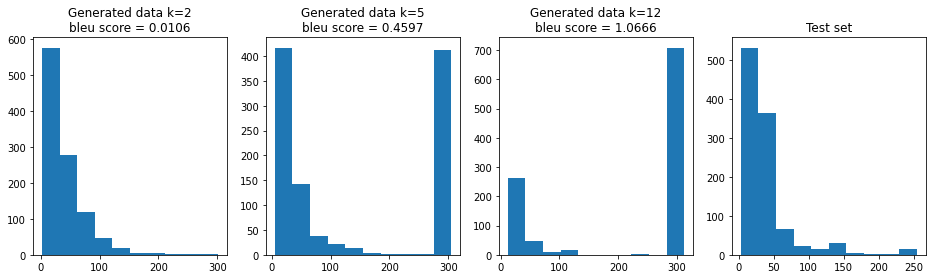

In [ ]:
fig = plt.figure(figsize=(16,4))
axes = [plt.subplot(1,4, i+1) for i in range(4)]
k_array = [2,5,12]
for j in range(3):
  k = k_array[j]
  bleu_scr = 0
  model = MarkovChain(train,k)
  generated_list = []
  for i in range(len(test)):
    generated_str = generateText(test[i][0:k],k,L_max=300)
    bleu_scr += bleu_score(generated_str, test[i])
    generated_list.append(generated_str)

  bleu_scr = bleu_scr/len(test)
  print(bleu_scr)
  generated_list = np.array(generated_list)

  axes[j].hist([len(seq) for seq in generated_list])
  axes[j].set_title('Generated data k='+str(k)+'\n'+'bleu score = %.4f'%(bleu_scr))

axes[3].hist([len(seq) for seq in test])
axes[3].set_title('Test set')

# LSTM

In [ ]:
batch_size=128
hidden_dim = 256
all_letters = '0'+''.join(list(set(''.join(positive_examples))))

In [ ]:
class PosSeq(Dataset):
  def __init__(self):
    data = list(positive_examples)
    self.all_letters = '0'+''.join(list(set(''.join(positive_examples))))
    L = len(all_letters)
    self.lens = [len(s)+1 for s in data]
    self.data = [torch.stack([torch.eye(L)[all_letters.find(c)] for c in d]+[torch.eye(L)[0]]) for d in data]
    self.orig = [torch.stack([torch.Tensor([all_letters.find(c)]) for c in d]+[torch.Tensor([0])]) for d in data]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.orig[index], self.data[index], self.lens[index]

posseq = PosSeq()

In [ ]:
train_length = int(len(posseq)*0.8)
train_data, valid_data = torch.utils.data.random_split(posseq, [train_length, len(posseq)-train_length])

In [ ]:
def collate(xs):
  os, ss, ls = list(zip(*xs))
  max_len = max(ls)
  ss = [torch.cat([s]+[torch.zeros(s.shape[1]).repeat(max_len-s.shape[0], 1)], dim=0) for s in ss]
  ss = torch.stack(ss, dim=0)
  os = [torch.cat([o]+[torch.Tensor([64]).repeat(max_len-o.shape[0], 1)], dim=0) for o in os]
  os = torch.stack(os, dim=0)
  return os, ss, ls
  

train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=collate)
valid_loader = DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.lstm = nn.LSTM(input_size=21, hidden_size=hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, 21, bias=True)

  def forward(self, batch):
    os, seqs, lens = batch
    batch_size, seq_len, _ = seqs.size()
    X = nn.utils.rnn.pack_padded_sequence(seqs, lengths=lens, batch_first=True, enforce_sorted=False)
    X, h =  self.lstm(X, (torch.zeros(1, batch_size, hidden_dim).cuda(), torch.zeros(1, batch_size, hidden_dim).cuda()))
    X, lens = nn.utils.rnn.pad_packed_sequence(X, batch_first=True)
    X = X.contiguous()
    X = X.view(-1, X.shape[2])
    Yhat = nn.functional.log_softmax(self.fc(X), dim=1).view(batch_size, seq_len, 21)
    return Yhat

model = Model()

Train model

In [ ]:
model = model.cuda()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)

def loss_on_batch(batch):
  os, seqs, lens = batch
  os = os.cuda()
  seqs = seqs.cuda()
  batch = os, seqs, lens
  
  Y = os[:, 1:]
  # Y = Y.reshape(-1)
  mask = (Y < 64).float()

  yhat = model(batch) 
  yhat = yhat[:, :-1, :]
  # yhat = yhat.reshape(-1, 21)

  loss = 0
  criterion = nn.NLLLoss()
  for i in range(yhat.shape[0]): 
    yhati = yhat[i].reshape(-1, 21)
    Yi = Y[i].long().squeeze(-1)
    maski = mask[i].reshape(-1)
    length = int(maski.sum().item())
    loss = loss + criterion(yhati[:length, :], Yi[:length])/length
  loss = loss / yhat.shape[0]

  return loss

train_loss = []
valid_loss = []
for e in range(20):
  tlosses = []
  vlosses = []

  for batch in train_loader:
    loss = loss_on_batch(batch)
    optim.zero_grad()
    loss.backward()
    optim.step()
    tlosses.append(loss.item())

  for batch in valid_loader:
    loss = loss_on_batch(batch)
    vlosses.append(loss.item())  

  train_loss.append(sum(tlosses)/len(tlosses))
  valid_loss.append(sum(vlosses)/len(vlosses)) 
  print('epoch', e, 'training loss', train_loss[-1], 'validation loss', valid_loss[-1])

epoch 0 training loss 0.12314306222128146 validation loss 0.11630559629864162
epoch 1 training loss 0.1166031529957598 validation loss 0.10900834699471791
epoch 2 training loss 0.1102797377741698 validation loss 0.10467877487341563
epoch 3 training loss 0.10514479107928998 validation loss 0.10042884945869446
epoch 4 training loss 0.09983759892709328 validation loss 0.0974415789047877
epoch 5 training loss 0.09464243844603047 validation loss 0.09504007299741109
epoch 6 training loss 0.08971875477017778 validation loss 0.09309602528810501
epoch 7 training loss 0.0847858978491841 validation loss 0.09106856750117408
epoch 8 training loss 0.08051477959661772 validation loss 0.0896737203001976
epoch 9 training loss 0.07644568790089 validation loss 0.0884312887986501
epoch 10 training loss 0.07271229272538965 validation loss 0.08791268782483207
epoch 11 training loss 0.06963845951990648 validation loss 0.08752423938777712
epoch 12 training loss 0.0663886811922897 validation loss 0.08808812002

Text(0, 0.5, 'loss')

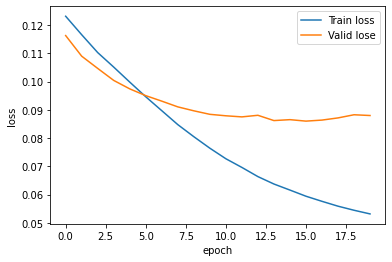

In [ ]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(["Train loss", "Valid lose"])
plt.xlabel("epoch")
plt.ylabel("loss")

Validate

In [ ]:
def sample(o, seq, l):
  with torch.no_grad():
    o = o.cuda()
    seq = seq.cuda()
    while True:
      p = model.forward((o, seq, l))[:, -1, :]
      p = torch.exp(p.reshape(-1))
      sample = np.random.choice(list(range(21)), size=(1), p=p.cpu().numpy())
      l = (l[0]+1,)
      o = torch.cat([o]+[torch.Tensor(sample).cuda().reshape(1, 1, 1)], dim=1)
      seq = torch.cat([seq]+[torch.Tensor(torch.eye(seq.shape[2])[sample]).cuda().reshape(1, 1, -1)], dim=1)
      if sample == 0 or seq.shape[1] > 400:
        break
  return ''.join([all_letters[i.long()] for i in o.reshape(-1)])

Text(0.5, 1.0, 'Test set')

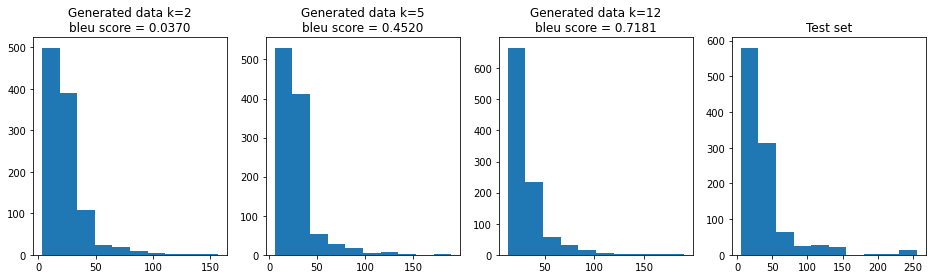

In [ ]:
fig = plt.figure(figsize=(16,4))
axes = [plt.subplot(1,4, i+1) for i in range(4)]
endi_t = [2,5,12]
for i in range(3):

  bleu_scr = 0
  endi = endi_t[i]
  generated_string = []
  for valbatch in valid_loader:
    for index in range(valbatch[0].shape[0]): 
      o, seq, l = valbatch[0][index:index+1], valbatch[1][index:index+1], valbatch[2][index:index+1]
      if l[0]<endi:
        continue
      o = o[:, :endi, :]
      seq = seq[:, :endi, :]
      l = (endi,)
      pred = sample(o, seq, l)
      target =  ''.join([all_letters[i.long()] for i in valbatch[0][index].reshape(-1)[: valbatch[2][index]]])
      generated_string.append(pred)
      bleu_scr += bleu_score(target,pred)
  bleu_scr = (bleu_scr/len(valid_data))
  axes[i].hist([len(seq) for seq in generated_string])
  axes[i].set_title('Generated data k='+str(endi)+'\n'+'bleu score = %.4f'%(bleu_scr))

validation_string = []
for j in range(len(valid_data)):
  validation_string.append(''.join([all_letters[i.long()] for i in valid_data[j][0][:valid_data[j][2]]]))
axes[3].hist([len(seq) for seq in validation_string])
axes[3].set_title('Test set')

As you can see, the Markov model couldn't generalize well and when we increase the size of the input string, detecting the end of the string for the Markov model gets harder and harder and we can see a pick at the right side of the distribution. On the other hand, in the LSTM model, when we increase the input string's size, the distribution gets closer to the validation set and the bleu score increased. 